# Validation of RKHorn With the Neutrino Fluxes

In [ ]:
import numpy as np
from numpy import sin, pi
import matplotlib.pyplot as plt

from matplotlib import cm, ticker
from matplotlib.pylab import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

import sys
sys.path.append("../")
from rkhorn import *


#### Simulate the $\pi^+$ and $K^+$ fluxes using rkhorn.charged_meson_flux_mc and a custom neutrino flux class, ```ChargedMesonNeutrinoFlux```

In [2]:


# Generate K+ and Pi+ flux
nsamples = 294377  # tuned to the same number of samples in the data files below
k_plus_flux = charged_meson_flux_mc("k_plus", 0.0, 6.5, 0.03, 0.21, n_samples=nsamples, n_pot=1.0)
pi_plus_flux = charged_meson_flux_mc("pi_plus", 0.0, 6.5, 0.03, 0.21, n_samples=nsamples, n_pot=1.0)

# import RKHorn-generated pion flux
rkhorn_pion_data = np.genfromtxt("data/bnb_focused_piplus_flux_rkhorn_1POT_BetheBloch_25.txt")
rkhorn_kaon_data = np.genfromtxt("data/bnb_focused_Kplus_flux_rkhorn_1POT_BetheBloch.txt")
rkhorn_piminus_data = np.genfromtxt("data/bnb_focused_piminus_flux_rkhorn_1POT_BetheBloch_25.txt")

# columns: pi_momenta_post_horn, pi_thetas_post_horn, decay_x, decay_y, decay_z, decay_wgts, pi_weights_post_horn
# create minimal array for ChargedMesonNeutrinoFlux
pi_plus_flux_rkhorn = rkhorn_pion_data[rkhorn_pion_data[:,5] > 0]
K_plus_flux_rkhorn = rkhorn_kaon_data[rkhorn_kaon_data[:,5] > 0]
pi_minus_flux_rkhorn = rkhorn_piminus_data[rkhorn_piminus_data[:,5] > 0]


class ChargedMesonNeutrinoFlux:
    def __init__(self, meson_flux, meson_type="pion", m_lepton=M_MU, energy_cut=140.0, n_samples=1):
        self.meson_flux = meson_flux
        if meson_type == "pion":
            self.mm = M_PI
            self.ckm = V_UD
            self.fM = F_PI
            self.total_width = PION_WIDTH
        elif meson_type == "kaon":
            self.mm = M_K
            self.ckm = V_US
            self.fM = F_K
            self.total_width = KAON_WIDTH
        else:
            raise Exception("Meson type not understood!", meson_type)
        self.m_lepton = m_lepton
        self.det_dist = 541
        self.dump_dist = 50
        self.det_length = 12
        self.solid_angles = []
        self.energy_cut = energy_cut
        self.nsamples = n_samples
        self.energies = []
        self.cosines = []
        self.decay_pos = []
        self.weights = []
    
    def partial_width(self):
        return np.clip((G_F*self.fM*self.m_lepton*self.ckm)**2 * self.mm * (1-(self.m_lepton/self.mm)**2)**2 / (8*pi), a_min=0.0, a_max=np.inf)
    
    def br(self):
        return self.partial_width()/self.total_width

    def simulate_neutrinos(self):
        M_M = self.mm

        # Reproduce the neutrino flux abundance
        p_k = self.meson_flux[:,0]
        wgt_k = self.meson_flux[:,2]

        phi_rnd = 2*np.pi*np.random.ranf(nsamples)
        theta_rnd = arccos(1 - 2*np.random.ranf(nsamples))
        c_rnd = cos(theta_rnd)
        e_nu = (M_M**2 - M_MU**2)/(2*M_M)
        p_nu_z = e_nu * c_rnd

        beta = p_k / sqrt(p_k**2 + M_M**2)
        gamma = np.power(1-beta**2, -0.5)
        e_nu_lab = gamma*(e_nu + beta*p_nu_z)
        p_nu_z_lab = gamma*(p_nu_z + beta*e_nu)
        cos_lab = p_nu_z_lab / e_nu_lab

        # TODO: simulate decay position
        decay_l = METER_BY_MEV * p_k / self.partial_width() / self.mm
        u = []
        for l in decay_l:
            umax = exp(-2*self.dump_dist/l) * power(exp(self.dump_dist/l) - 1, 2) \
                if l > 1.0 else 1.0
            u.append(np.random.uniform(0.0, min(umax, 1.0)))
        
        x = decay_quantile(np.array(u), p_k, self.mm, self.partial_width())
        
        # Append decay positions and solid angle cosines for the geometric acceptance of each meson decay
        self.decay_pos.append(x)
        solid_angle_cosine = cos(arctan(self.det_length/(self.det_dist-x)/2))

        wgt_nu = self.br() * wgt_k * heaviside(cos_lab - solid_angle_cosine, 0.0)  * (2 * (max(e_nu_lab)-min(e_nu_lab)))
        return e_nu_lab, wgt_nu
    
    def simulate_neutrinos_from_decayed_flux(self):
        self.energies = []
        self.cosines = []
        self.decay_pos = []
        self.weights = []

        det_vector = np.array([0,0,self.det_dist])

        meson_p4 = LorentzVector(self.mm, 0.0, 0.0, 0.0)
        mc = Decay2Body(p_parent=LorentzVector(self.mm, 0.0, 0.0, 0.0), m1=0.0, m2=self.m_lepton, n_samples=self.nsamples)
        phis = np.random.uniform(0.0, 2*pi, self.meson_flux.shape[0]*self.nsamples)

        for i, m in tqdm(enumerate(self.meson_flux)):
            p_m = m[0]
            theta_m = m[1]
            x = m[2]
            y = m[3]
            z = m[4]

            flux_wgt = m[6]

            meson_p4.set_p4(sqrt(p_m**2 + self.mm**2), p_m*sin(theta_m)*cos(phis[i]),
                                                        p_m*sin(theta_m)*sin(phis[i]),
                                                        p_m*cos(theta_m))
            mc.set_new_decay(meson_p4, 0.0, self.m_lepton)
            mc.decay()

            nu_p4s = mc.p1_lab_4vectors

            for nu_p4 in nu_p4s:
                # determine the dot product between the neutrino production position vector and the detector vector
                lnu = det_vector - np.array([x,y,z])
                dist_to_det = np.sqrt(np.sum(lnu*lnu))
                pnu = np.array([nu_p4.p1, nu_p4.p2, nu_p4.p3])
                theta_nu_det = arccos(np.dot(lnu, pnu)/(nu_p4.momentum()*dist_to_det))

                self.energies.append(nu_p4.energy())
                self.cosines.append(nu_p4.cosine())
                self.weights.append(flux_wgt*heaviside(self.det_length/dist_to_det - theta_nu_det, 0.0)/self.nsamples)

            
        
        return np.array(self.energies), np.array(self.weights)



Use the ```ChargedMesonNeutrinoFlux``` class to simulate some samples, where ```n_samples=50``` draws 50 weighted MC subsamples for every sample in the RKHorn horn-focused meson fluxes.

42109it [01:37, 432.40it/s]
41552it [01:37, 424.34it/s]


Sum of weights RKHorn = 0.0018408653583980904


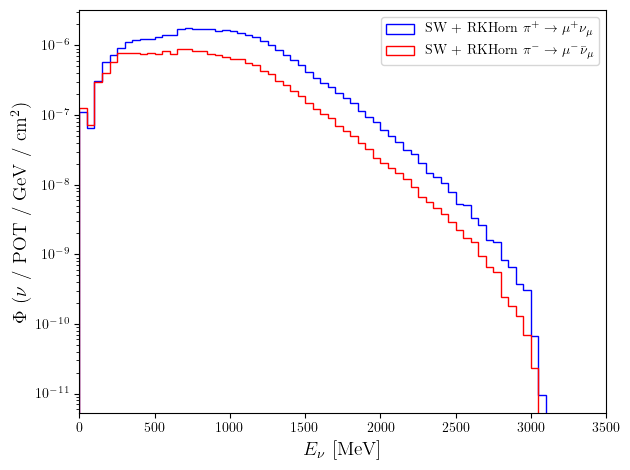

In [3]:


# Simulate K+ and pi+ sourced neutrino fluxes

# With Horn Focusing
pion_nu_rkhorn = ChargedMesonNeutrinoFlux(pi_plus_flux_rkhorn, meson_type="pion", n_samples=50)
pion_nubar_rkhorn = ChargedMesonNeutrinoFlux(pi_minus_flux_rkhorn, meson_type="pion", n_samples=50)
#kaon_nu_rkhorn = ChargedMesonNeutrinoFlux(K_plus_flux_rkhorn, meson_type="kaon", n_samples=50)

nu_pi_e_rk, nu_pi_wgts_rk = pion_nu_rkhorn.simulate_neutrinos_from_decayed_flux()
nubar_pi_e_rk, nubar_pi_wgts_rk = pion_nubar_rkhorn.simulate_neutrinos_from_decayed_flux()
#nu_K_e_rk, nu_K_wgts_rk = kaon_nu_rkhorn.simulate_neutrinos_from_decayed_flux()

print("Sum of weights RKHorn = {}".format(np.sum(nu_pi_wgts_rk)))


# compare to rates / 50 MeV / POT with PhysRevD.79, 072002 (2009)
# Plotting the differential Enu spectrum
energy_bins_50 = np.arange(0.0, 3800, 50)
energy_bin_centers = (energy_bins_50[1:] + energy_bins_50[:-1])/2
bin_width = energy_bins_50[1] - energy_bins_50[0]

# Get bin width divided fluxes
h_nu, _ = np.histogram(nu_pi_e_rk, weights=nu_pi_wgts_rk, bins=energy_bins_50)
h_nubar, _ = np.histogram(nubar_pi_e_rk, weights=nubar_pi_wgts_rk, bins=energy_bins_50)

h_nu /= bin_width
h_nubar /= bin_width

plt.hist(energy_bin_centers, weights=h_nu, bins=energy_bins_50, histtype='step',
            label=r"SW + RKHorn $\pi^+ \to \mu^+ \nu_\mu$", color="b")
plt.hist(energy_bin_centers, weights=h_nubar, bins=energy_bins_50, histtype='step',
            label=r"SW + RKHorn $\pi^- \to \mu^- \bar{\nu}_\mu$", color="r")
plt.xlim((0.0,3500.0))
plt.yscale('log')
plt.xlabel(r"$E_\nu$ [MeV]", fontsize=14)
plt.ylabel(r"$\Phi$ ($\nu$ / POT / GeV / cm$^2$)", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

## Import reported flux from Phys.Rev.D 79 (2009) 072002 [https://arxiv.org/pdf/0806.1449]

In [4]:
numu_flux_by_GeV_POT_cm2 = np.genfromtxt("data/public_digitized_fluxes/numu_diff_flux_by_POT_GeV_cm2.txt")
numubar_flux_by_GeV_POT_cm2 = np.genfromtxt("data/public_digitized_fluxes/numubar_diff_flux_by_POT_GeV_cm2.txt")

def numu_flux_interp(Enu):
    return np.interp(Enu, numu_flux_by_GeV_POT_cm2[:,0], numu_flux_by_GeV_POT_cm2[:,1])

def numubar_flux_interp(Enu):
    return np.interp(Enu, numubar_flux_by_GeV_POT_cm2[:,0], numubar_flux_by_GeV_POT_cm2[:,1])

Now we compare the muon neutrino fluxes from pions and kaons to those reported in the PRD paper above;

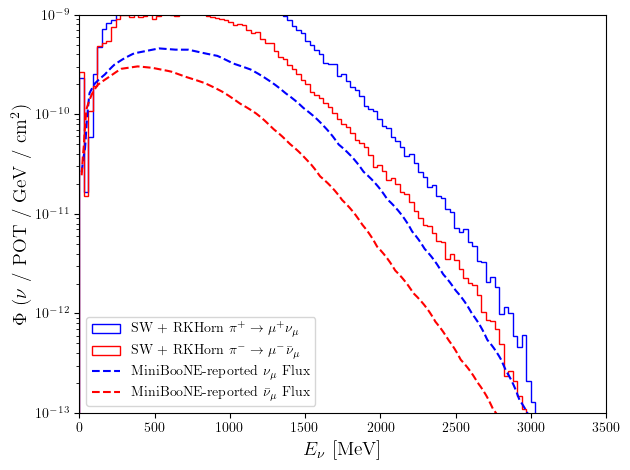

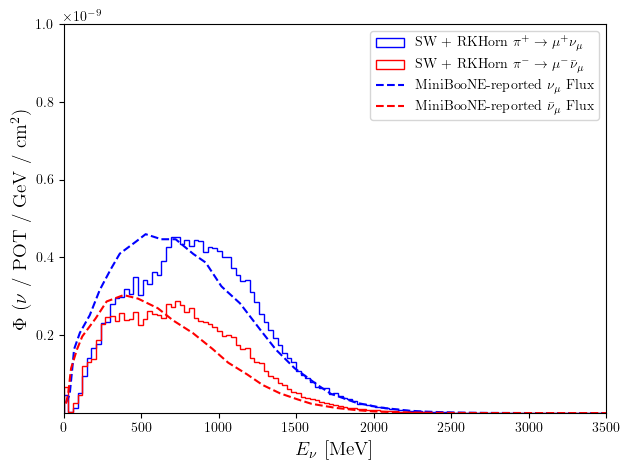

In [8]:
# Get bin width divided fluxes
energy_bins_100 = np.arange(0.0, 3800, 30)
bin_centers_100 = (energy_bins_100[1:] + energy_bins_100[:-1])/2
bin_width_100 = energy_bins_100[1] - energy_bins_100[0]

h_nu, _ = np.histogram(nu_pi_e_rk, weights=nu_pi_wgts_rk, bins=energy_bins_100)
h_nubar, _ = np.histogram(nubar_pi_e_rk, weights=nubar_pi_wgts_rk, bins=energy_bins_100)

det_area_cm = np.pi*np.power(500, 2)  # Fiducial area of ~10m diameter  --> 500cm radius

h_nu /= (bin_width_100*1e-3 * det_area_cm)
h_nubar /= (bin_width_100*1e-3 * det_area_cm)  # divide by bin width in GeV and detector area


# Generate comparison from PRD
Enu_vals = np.linspace(bin_centers_100[0], bin_centers_100[-1], 1000)
numu_flux_public = numu_flux_interp(Enu_vals)
numubar_flux_public = numubar_flux_interp(Enu_vals)


plt.hist(bin_centers_100, weights=h_nu, bins=energy_bins_100, histtype='step',
            label=r"SW + RKHorn $\pi^+ \to \mu^+ \nu_\mu$", color="b")
plt.hist(bin_centers_100, weights=h_nubar, bins=energy_bins_100, histtype='step',
            label=r"SW + RKHorn $\pi^- \to \mu^- \bar{\nu}_\mu$", color="r")

plt.plot(Enu_vals, numu_flux_public, color='b', ls='dashed', label=r"MiniBooNE-reported $\nu_\mu$ Flux")
plt.plot(Enu_vals, numubar_flux_public, color='r', ls='dashed', label=r"MiniBooNE-reported $\bar{\nu}_\mu$ Flux")

plt.xlim((0.0,3500.0))
plt.yscale('log')
plt.ylim((1e-13, 1e-9))
plt.xlabel(r"$E_\nu$ [MeV]", fontsize=14)
plt.ylabel(r"$\Phi$ ($\nu$ / POT / GeV / cm$^2$)", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()


plt.hist(bin_centers_100, weights=h_nu/5, bins=energy_bins_100, histtype='step',
            label=r"SW + RKHorn $\pi^+ \to \mu^+ \nu_\mu$", color="b")
plt.hist(bin_centers_100, weights=h_nubar/4, bins=energy_bins_100, histtype='step',
            label=r"SW + RKHorn $\pi^- \to \mu^- \bar{\nu}_\mu$", color="r")

plt.plot(Enu_vals, numu_flux_public, color='b', ls='dashed', label=r"MiniBooNE-reported $\nu_\mu$ Flux")
plt.plot(Enu_vals, numubar_flux_public, color='r', ls='dashed', label=r"MiniBooNE-reported $\bar{\nu}_\mu$ Flux")

plt.xlim((0.0,3500.0))
plt.ylim((1e-13, 1e-9))
plt.xlabel(r"$E_\nu$ [MeV]", fontsize=14)
plt.ylabel(r"$\Phi$ ($\nu$ / POT / GeV / cm$^2$)", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()